## Intro
I advise you to create special folder - Let's call it _'AlexFinal'_ for our results, and sequentially Copy-Pasty results to it. 

#  Comparison with existing methods

In that subsection we demonstrate that existing methods for sampling in networks is not good for FSN.

1. Run GRID script (SensitivityAnalysis.py) for all strategies, the rect parameters set as the optimal ones:

``"Strategy": ["MetaUniform", "OriginalRandomWalk", "DefUniform", "MetaDiff"]``

As a result, we have Excel file - please copy it to _'AlexFinal'_. Also copy all images per each strategy: from OriginalRandomWalk folder, from DefUniform, from MetaUniform and from MetaDiff.

Now in _'AlexFinal'_ we should have one excel file with comparison of methods AND 4 folders (one per each strategy).

# Results interpretation

In that section we make an attempt to understand how our approach works etc.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Upload your optimal embeddings

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from NetEmbs import *

# Specify here the number of groups in your data. 
# I'm not sure should we use the finest strucre (25) or make preelemenatry merging... What do you think?
N_CLS = 11
# Min and Max number of clusters to investigate the chagnes in merging processes.
MIN_MAX_CLS = (8, 13)

IMAGE_FOLDER = "AlexFinal"
create_folder(IMAGE_FOLDER)


MODE = "SimulatedData"
DB_PATH = "Simulation/FSN_Data_5k.db"
# CONFIG.ROOT_FOLDER = "UvA/GoogleColab/Optimal 5k/"
CONFIG.ROOT_FOLDER = "Uva/LargeDataset/"
CONFIG.EXPERIMENT = [0, 1]

#  ---------- CONFIG Setting HERE ------------
# .1 Sampling parameters
CONFIG.STRATEGY = "MetaDiff"
CONFIG.PRESSURE = 10
CONFIG.WINDOW_SIZE = 2
CONFIG.WALKS_PER_NODE = 30
CONFIG.WALKS_LENGTH = 10
# .2 TF parameters
CONFIG.STEPS = 100000
CONFIG.EMBD_SIZE = 8
CONFIG.LOSS_FUNCTION = "NegativeSampling"  # or "NCE"
CONFIG.BATCH_SIZE = 256
CONFIG.NEGATIVE_SAMPLES = 512

updateCONFIG(False)
EMBS_PATH = CONFIG.WORK_FOLDER[0]+CONFIG.WORK_FOLDER[1]+CONFIG.WORK_FOLDER[2]

if MODE == "SimulatedData":
    embs = pd.read_pickle(EMBS_PATH+"Embeddings.pkl")
    print("Embeddings have been uploaded to memory!")
    d = upload_data(DB_PATH, limit=None)
    d = prepare_data(d)
    print("Supported information has been uploaded to memory!")

if MODE == "RealData":
    import extras
    import analysis
    EMBS_PATH = "model/15108_2017_versionMetaDiff_directionCOMBI_walks31_pressure30_window3/TFsteps100000batch64_emb32/"
    embs = pd.read_pickle(EMBS_PATH+"cache/Embeddings.pkl")
        # //////// TODO UPLOAD your data HERE \\\\\\\\\\
#     d = analysis.analysis("14082_2017")
    d = extras.getData("15108_2017")
        # //////// END  \\\\\\\\\\
    # TODO pay attention for the split argument below!
    if "Value" in list(d):
        need_split = True
    else:
        need_split = False
    d = prepare_dataMarcel(d, split=need_split)
#     Here we drop the duplicate of GroundTruth in the DataFrame with supported info, because we have it in Embs DataFrame
    if "GroundTruth" in list(d):
        d.drop("GroundTruth", axis=1, inplace=True)
print("Shape of uploaded Dataset is ", d.shape)

Config file has been updated!
Embeddings have been uploaded to memory!
Final shape of DataFrame is  (29239, 9)
Supported information has been uploaded to memory!
Shape of uploaded Dataset is  (29239, 9)


## Clusterize here

In [30]:
embs = cl_Agglomerative(embs, N_CLS)

First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]


In [4]:
plot_tSNE(embs, legend_title="GroundTruth", title=IMAGE_FOLDER+"/GT_MetaDiff", context="talk_full")

In [32]:
for cl_n in range(*MIN_MAX_CLS):
    embs = cl_Agglomerative(embs, cl_n)
    embs.groupby(["GroundTruth", "label"])["ID"].count()\
        .unstack().fillna(0).apply(lambda x: x / x.sum(), axis = 1)\
        .to_excel(f"{IMAGE_FOLDER}/confusion{str(cl_n)}.xlsx")
    plot_tSNE(embs, legend_title="label", title=IMAGE_FOLDER+"/pre_MetaDiff_"+str(cl_n), context="talk_half")
    print(f"Done with {cl_n} clusters!")

First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]
Done with 8 clusters!
First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]
Done with 9 clusters!
First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]
Done with 10 clusters!
First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]
Done with 11 clusters!
First row of Data: 
 [-0.38152471 -0.34886238  0.20825255  0.32573476  0.44090793  0.31327802
  0.43619904 -0.31693727]
Done with 12 clusters!


# Uncovering the actual meaning

If I understood you correctly, it is impossible to post the same images as you send to your colleagues. So, let's just add to our thesis to that section their feedback, I guess it should be OK as well as demonstrates that we actively communicate with experts from the field of study :)

In [38]:
from __future__ import print_function
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from ipywidgets import interactive, HBox, VBox, widgets

## Interactive vis for you to undersand the meaning of cluster for further modelling

In [39]:
from NetEmbs.Vis.helpers import set_font, getColors_Markers
from NetEmbs.Vis.words_cloud import findMostCommonFAs_v2
# Label text
description = widgets.Label(
        value=''
    )
# WordCouds area
wordCloudsOutput = widgets.Output()
# Table with JournalEntries data
table_titles = ["ID", "FA_Name", "Credit", "Debit", "label"]
format_style = [[None], [None], ['.4f'], ['.4f'], [None]]

if MODE == "RealData":
    table_titles = ["ID", "FA_Name", "accountDesc", "Credit", "Debit", "label"]
    format_style = [[None], [None], [None], ['.4f'], ['.4f'], [None]]

t = go.FigureWidget([go.Table(
    header=dict(values=table_titles,
                fill = dict(color='#E5F1DC'),
                align = ['center'] * 5),
    cells=dict(values=[],
               format = format_style,
#                fill = dict(color='white'),
               align = ['center'] * 5))],
                    layout = go.Layout(
                            title="Journal Entries",
                            autosize=True,
                            width=1000,
                            height=400))  
# Scatter plot
N_COLORS = 10
WORD_CLOUD_LABEL = "FA_Name"
LEGEND_TITLE = "GroundTruth"
# LEGEND_TITLE = "label"

tmp_p_see = None
# For selection via multiple traces... stupid way.
indexes = []
tr_nums = 0


def interactiveScatter(df, df_info, legend_title="label"):
    """Create FigureWidget with the scatter plot for the given DataFrame"""
    scatter_data = list()
    cmap, mmap = getColors_Markers(keys=df[legend_title].unique(), cm="tab10", n_colors=N_COLORS, markers=["circle", "diamond", "square"])
    for name, group in df.groupby(legend_title):
        scatter_data.append(go.Scatter(x=group.x, y=group.y, mode='markers', name=name, 
                                    text = group.apply(lambda row: f"ID={row.ID},   GroundTruth={row.GroundTruth}", axis=1),
                                    customdata = group.index.to_list(),
                                    marker=dict(color=cmap[name][1], 
                                                symbol=mmap[name])))
    f = go.FigureWidget(data=scatter_data,
                       layout = go.Layout(
                           title=f"t-SNE visualisation with coloring based on {legend_title}",
        hovermode='closest',
        autosize=True,
        width=1000,
        height=700))
    
    def printSignature(trace, points, *args):
        if len(points.point_inds)>0:
            ids = trace.customdata[points.point_inds[0]]
            row = df.iloc[ids]
            description.value = f"ID={row.ID},   GroundTruth={row.GroundTruth}"
    def selectBP(trace, points, *args):
        if len(points.point_inds)>0:
            ids = trace.customdata[points.point_inds[0]]
            row = df.iloc[[ids]]
            chosen_bps = df_info.merge(row, on="ID")
            wordCloudsOutput.clear_output()
            t.data[0].cells.values = [chosen_bps[col] for col in t.data[0].header.values]
    
    def filterRows(selected_ids):
        row = df.iloc[selected_ids]
        chosen_bps = df_info.merge(row, on="ID")
        return chosen_bps
    def updateTable(chosen_bps):
        t.data[0].cells.values = [chosen_bps[col] for col in t.data[0].header.values]
    def showClouds(chosen_bps):
        wordCloudsOutput.clear_output()
        with wordCloudsOutput:
            findMostCommonFAs_v2(chosen_bps, LEGEND_TITLE, WORD_CLOUD_LABEL, sort_mode="freq", vis=True, n_top=4)
    scatters = f.data
    max_traces = len(scatters)
    def selectBPs(trace,points,selector):
        global indexes
        global tr_nums
#         print(f"For trace index={points.trace_index} tr_nums is {tr_nums}")
        if not points.point_inds:
            pass
        else:
            indexes.extend([trace.customdata[cur_point] for cur_point in points.point_inds])
        tr_nums = tr_nums+1
        if tr_nums==max_traces:
            selected_data = filterRows(indexes)
            updateTable(selected_data)
            showClouds(selected_data)
            indexes = []
            tr_nums = 0
    # Hover text: ID and GroundTruth
    for scatter in scatters:
        scatter.hoverinfo = 'text'
        scatter.on_hover(printSignature) 
        scatter.on_click(selectBP)
        scatter.on_selection(selectBPs)

    # Selection
    return f
# @interact(Coloring=['label', 'GroundTruth'])
# def update(Coloring="label"):
#     print(Coloring)
#     f_scatter = interactiveScatter(embs, Coloring)
#     return VBox([description, f_scatter])
f_scatter = interactiveScatter(embs, d, LEGEND_TITLE)
VBox([description, f_scatter, t, wordCloudsOutput])

    'data': [{'customdata': [27, 34, 38, ..., 5031, 5034, 5035]…

# Modelling graphs

Install additional packages for saving figures from Plotly:

``conda install -c plotly plotly-orca psutil requests``

In [35]:
# TODO helper uploader for obtain Time column. 
if MODE=="SimulatedData":
    df_all = d.drop(["Signature", "Name"], axis=1)
    print(f"Shape of supported info is {df_all.shape}, shape of embs DataFrame is {embs.shape}")
    df_all = df_all.merge(embs, on="ID")
    print(f"After merge the shape is {df_all.shape}")
    df_all = df_all.groupby(["ID", "FA_Name", "from"], as_index=False).aggregate({"amount": lambda x: np.sum(x), 
                                "Time": "first",
                              "GroundTruth": "first",
                              "label": "first",
                              "x": "first",
                              "y": "first"}) \
                        .sort_values("Time", ascending=True)
if MODE=="RealData":
    d["Date"] = pd.to_datetime(d["Date"],format='%Y-%m-%d')
#     df_all = d.groupby("ID", as_index=False).aggregate({"amount": lambda x: np.sum(x)/2.0, 
#                                "Date": "first"}).merge(embs, on="ID").sort_values("Date", ascending=True)
    df_all = d.groupby(["ID", "FA_Name", "from"], as_index=False)\
                .aggregate({"amount": lambda x: np.sum(x), 
                            "Date": "first",
                           "accountDesc": "first"})\
                .merge(embs, on="ID")\
                .sort_values("Date", ascending=True)
    df_all.set_index(df_all.Date, inplace=True)
df_all["flow"] = df_all["from"].apply(lambda x: {False: "inflow", True: "outflow" }[x])
df_all.head(2)

Shape of supported info is (29239, 7), shape of embs DataFrame is (5109, 7)
After merge the shape is (29239, 13)


,ID,FA_Name,from,amount,Time,GroundTruth,label,x,y,flow
0,7,FixedAssets,False,52.184404,0.67896,Fixed Assets,9,8.510545,-57.541683,inflow
1,7,NoisyLeftFA_kbfq,True,0.021187,0.67896,Fixed Assets,9,8.510545,-57.541683,outflow


In [36]:
def addDateTimeIndex(df):
    df["SimulatedTime"] = df["Time"]
    df["Time"] = df["Time"].apply(lambda x: np.datetime64('2019-01-01')+np.timedelta64(int(x*205.7), 'm'))
    return df.set_index("Time")
if MODE=="SimulatedData":
    df_all = addDateTimeIndex(df_all)

In [118]:
def filterData_v3(df, 
                  query=[{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "Revenue", "from": True}}, 
                 {"select": ["Collections"], "_with": None}], 
                  on="GroundTruth"):
    result = list()
    for q in query:
        postfix = {"FA_Name": None, "flow": None}
        if q["select"] is None or q["select"]==["ALL"] or q["select"]=="ALL":
            cur_df = df
            cur_df.name = "No processes information"
        else:
            cur_df = df[df[on].isin(q["select"])]
            if on=="GroundTruth":
                cur_df.name = "Expert label"
                if len(q["select"])>1:
                        cur_df.name+="s"
            elif on == "label":
                cur_df.name = "Cluster"
                if len(q["select"])>1:
                        cur_df.name+="s"
            cur_df.name+=" "+str(q["select"])[1:-1]
        tmp_name = cur_df.name
        if q["_with"] is not None:
            for key, value in q["_with"].items():
                try:
                    cur_df = cur_df[cur_df[key]==value]
                    postfix[key] = str(value)
                except KeyError as e:
                    raise(f"{a} is not in a columns titles!")
    
        if postfix["FA_Name"] is not None:
            tmp_name+=f" – {postfix['FA_Name']}"
        if postfix["flow"] is not None:
            tmp_name+=f"({postfix['flow']})"
        cur_df.name = tmp_name
        result.append(cur_df)
    if len(result)==1:
        return result[0]
    else:
        return tuple(result)

## Here is the ~map from Label to GroundTruth, but it could be wrong, because I simply take the most common GroundTruth for each predicted label. But, at least, it can help you I guess

In [40]:
labels_to_titles = embs.groupby("label").GroundTruth.agg(pd.Series.mode).to_dict()
labels_to_titles

{0: 'Goods delivery',
 1: 'Collections',
 2: 'Collections',
 3: 'Sales tax',
 4: 'Payroll',
 5: 'Sales 21 btw',
 6: 'Disbursement',
 7: 'Depreciation',
 8: 'Payroll Disbursement',
 9: 'Fixed Assets',
 10: 'Sales 6 btw',
 11: 'Purchase'}

## Hint! To make plots applicable for publication, I hide Y axis, now one does not know the values of monetary flow. Is it enough? 

Keep in mind, that if we change the amounts values or shift original Xaxis, it leads to changes in correlation between Time series (that was the first one I had tried...)

In [96]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np
def plotAmounts(DFs, aggtitle="Default signals", corr_score=None, filename="amounts_plot", anonym=False):
    """Helper funciton to plot a few DataFrame in one plotly graph"""
    if corr_score is not None:
        aggtitle = aggtitle + ".     Correlation: "+str(round(corr_score, 3))
    if len(DFs)>1:
            fig2 = go.Figure(data=[go.Scatter(x=df.index,
            y=df.amount,
            name=df.name
            ) for df in DFs], 
            layout = go.Layout(width=1200,
    height=400, showlegend=True, title=go.layout.Title(text=aggtitle), hovermode='closest', 
                               legend=dict(orientation="h", font=dict(size=18), xanchor='center', x=0.5, y=-0.1),
                              font=dict(size=18)))
    else:
            fig2 = go.Figure(data=go.Scatter(x=DFs.index,
            y=DFs.amount,
            name=DFs.name, 
            layout = go.Layout(width=1200,
            height=400, showlegend=True, title=go.layout.Title(text=aggtitle), hovermode='closest')))
    if anonym:
        fig2.layout.yaxis = go.layout.YAxis(showticklabels=False)
        fig2.layout.xaxis = go.layout.XAxis(showticklabels=False)
    iplot(fig2)
    fig2.write_image(filename+".pdf")

In [114]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

legend_postfix = {"W": ", weekly", "D": ", daily", "M": ", monthly", "2D": ", 2 days"}
def constructSignals_v2(df_all, shift=(0, 0), query=[{"select": [2], "_with": None}, {"select": [4], "_with": None}],
                        on="label", agg_period="W", title=None, legend=None, metric="MSE", scale_data=True):
    # Predicted labels
    agg_title = "Aggregated signals"
    left, right = filterData_v3(df_all, query=query, on=on)
    #     Make required shifts
    left_agg = left.shift(shift[0], freq="D")
    right_agg = right.shift(shift[1], freq="D")
    #     Aling TimeIndexes for correct aggregation.
    st_date = max(left_agg.index[0], right_agg.index[0])
    end_date = min(left_agg.index[-1], right_agg.index[-1])
    left_agg = left_agg[(left_agg.index >= st_date) & (left_agg.index <= end_date)]
    right_agg = right_agg[(right_agg.index >= st_date) & (right_agg.index <= end_date)]
    #     Makre required aggregation
    left_agg = left_agg.resample(agg_period).agg({"amount": sum})
    right_agg = right_agg.resample(agg_period).apply({"amount": sum})
    if legend is not None:
        left_agg.name = legend[0] + legend_postfix[agg_period]
        right_agg.name = legend[1] + legend_postfix[agg_period]
        agg_title += legend_postfix[agg_period]
    #     Add info about aggregation period to legen texts
    else:
        try:
            left_agg.name = left.name + legend_postfix[agg_period]
            right_agg.name = right.name + legend_postfix[agg_period]
            agg_title += legend_postfix[agg_period]
        except KeyError as e:
            left_agg.name = left.name + ", " + agg_period
            right_agg.name = right.name + ", " + agg_period
            agg_title += ", " + agg_period
    print(f"Correlation for given query and given shifts {shift} is \
          {left_agg.amount.corr(right_agg.amount)}")

    all_data = left_agg.join(right_agg, lsuffix="_X", rsuffix="_Y", how="inner")

    plotAmounts([left_agg, right_agg], agg_title, filename=title + "_" + agg_period,
                corr_score=left_agg.amount.corr(right_agg.amount), anonym=True)
    if scale_data:
        from sklearn.preprocessing import minmax_scale
        all_data["amount_Y"] = minmax_scale(all_data["amount_Y"])
        all_data["amount_X"] = minmax_scale(all_data["amount_X"])
    return all_data


def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.divide(np.abs((y_true - y_pred)), y_true, out=np.zeros_like(y_true), where=y_true!=0)) * 100

def NRMSD(true_labels, pred_labels):
    mse = mean_squared_error(true_labels, pred_labels)
    return np.sqrt(mse) / (np.subtract(*np.percentile(true_labels, [75, 25])))


def evaluate_model(df, metric="RMSE", n_runs=5):
    scores = list()
    lr = LinearRegression()
    if "amount_X" not in list(df) or "amount_Y" not in list(df):
        raise KeyError(f"Could not find the columns with X and Y in the given dataset... Titles are {list(df)}, while "
                       f"'amount_X' and 'amount_Y' required!")
    for r_s in range(n_runs):
        #         Make new split
        train, test = train_test_split(df, test_size=0.2, random_state=r_s)
        lr.fit(train.iloc[:, 0].values.reshape(-1, 1), train.iloc[:, 1].values.reshape(-1, 1))
        #         print("Coefficients in constructed linear regression model are: :", lr.coef_)
        tax_predicted = lr.predict(test[["amount_X"]])
        if metric == "MSE":
            scores.append(mean_squared_error(test[['amount_Y']], tax_predicted))
        elif metric == "RMSE":
            scores.append(np.sqrt(mean_squared_error(test[['amount_Y']], tax_predicted)))
        elif metric == "NRMSD":
            scores.append(NRMSD(test[['amount_Y']], tax_predicted))
        elif metric == "MAPE":
            scores.append(MAPE(test[['amount_Y']], tax_predicted))
    return scores

## Function for regression plots

In [128]:
def plotRegression(df, context="talk_full", labels = ["Outflow from Revenue", "Outflow from Tax"], title=None):
    dpi = 140
    fig_size = (11, 11)
    #     set_font(14, True)
    if context == "paper_half":
        sns.set_context("paper", font_scale=1.5)
        fig_size = (6.4, 4.8)
    if context == "paper_full":
        sns.set_context("paper", font_scale=1.8)
    if context == "talk_half":
        sns.set_context("paper", font_scale=3.5)
    if context == "talk_full":
        sns.set_context("paper", font_scale=2)
    cur_plot = sns.lmplot(x="amount_X", y="amount_Y", col="Model", data=df, col_wrap=2, height=5, aspect=1.5, scatter_kws=dict(s=70, alpha=0.75), line_kws=dict(alpha=0.8))\
        .set_titles(col_template = '{col_name}')\
        .set_xlabels(labels[0])\
        .set_ylabels(labels[1])\
        .set(xlim=(0, 1), ylim=(0, 1))
    cur_plot.fig.subplots_adjust(hspace=0.3, wspace=0.1)
    if title is not None:
        cur_plot.savefig(title + "RegressionPlot_for_" + context + ".png", bbox_inches="tight", dpi=dpi, pad_inches=0.05)
    plt.show(cur_plot)

# Your experiments with relationship

1. Start from CD model, where we do not use processes info -> `"select": ["ALL"]`
2. Then move to model based on the GroundTruth
3. And finally, use predicted labels

In [132]:
Relationship_name = "Tax"
TAX_REVENUE_DF = pd.DataFrame() # Empty DataFrame to store results
# CD Model query
CURENT_QUERY = [{"select": ["ALL"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["ALL"], "_with": {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W", "M"]:
    cur_result = constructSignals_v2(df_all, query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/CD_Model_Tax-Revenue_{agg_period}_",
                metric="RMSE")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="CD Model", agg_period=agg_period))
    
# Repeat the same for expert labels
# Expert Model query
CURENT_QUERY = [{"select": ["Sales 21 btw", "Sales 6 btw"], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": ["Sales 21 btw", "Sales 6 btw"], "_with": {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W", "M"]:
    cur_result = constructSignals_v2(df_all, query=CURENT_QUERY, 
                                 on="GroundTruth", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/expertFSN_Tax-Revenue_{agg_period}_",
                metric="RMSE")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Expert labels FSN Model", agg_period=agg_period))
    
# And predicted labels
# CD Model query
CURENT_QUERY = [{"select": [5, 10], 
                              "_with": {"FA_Name": "Revenue"}}, 
                                {"select": [5, 10], "_with": {"FA_Name": "Tax"}}]
for agg_period in ["2D", "W", "M"]:
    cur_result = constructSignals_v2(df_all, query=CURENT_QUERY, 
                                 on="label", agg_period=agg_period, 
                title=f"{IMAGE_FOLDER}/aFSN_Tax-Revenue_{agg_period}_",
                metric="RMSE")
    TAX_REVENUE_DF = TAX_REVENUE_DF.append(cur_result.assign(Model="Predicted labels FSN Model", agg_period=agg_period))
    
# Store scores to file
TAX_REVENUE_DF.groupby(["Model", "agg_period"]).apply(evaluate_model).to_excel(f"{IMAGE_FOLDER}/Scores_for_{Relationship_name}.xlsx")

Correlation for given query and given shifts (0, 0) is           0.6286277038441134


Correlation for given query and given shifts (0, 0) is           0.8173094111508721


Correlation for given query and given shifts (0, 0) is           0.940416638853333


Correlation for given query and given shifts (0, 0) is           0.9025550010896275


Correlation for given query and given shifts (0, 0) is           0.9485087812596132


Correlation for given query and given shifts (0, 0) is           0.9746631448080892


Correlation for given query and given shifts (0, 0) is           0.9025550010896275


Correlation for given query and given shifts (0, 0) is           0.9485087812596132


Correlation for given query and given shifts (0, 0) is           0.9746631448080892


## Now we can plot regression plots for each models and each aggregation period. 
### Do not worry, I scaled the data here to unit interval. Update Axis labels according to your data.

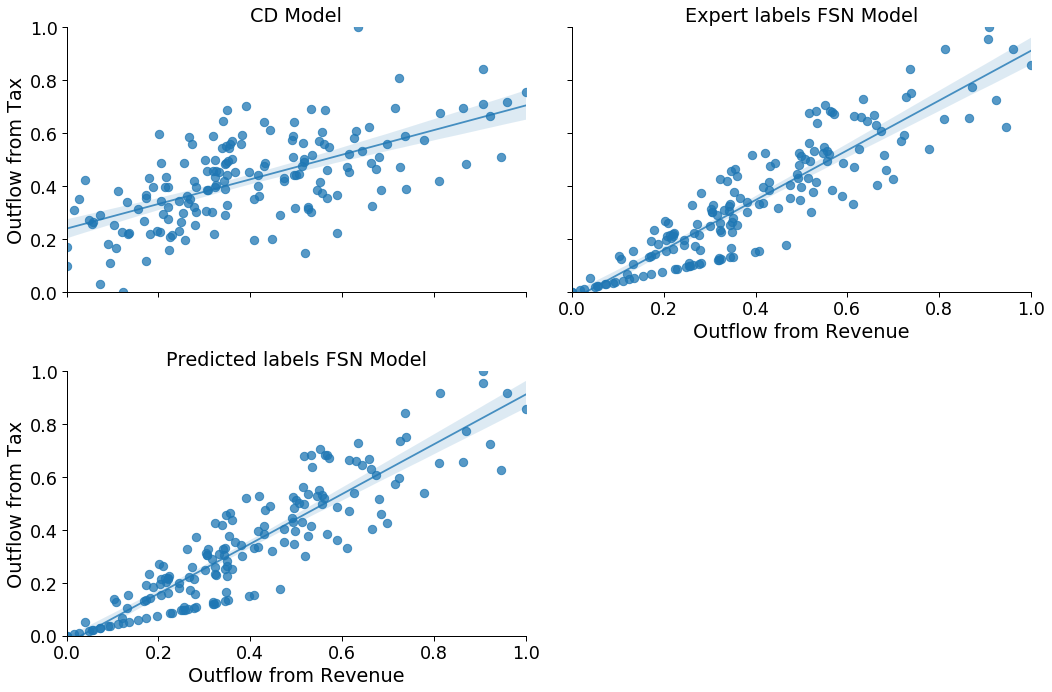

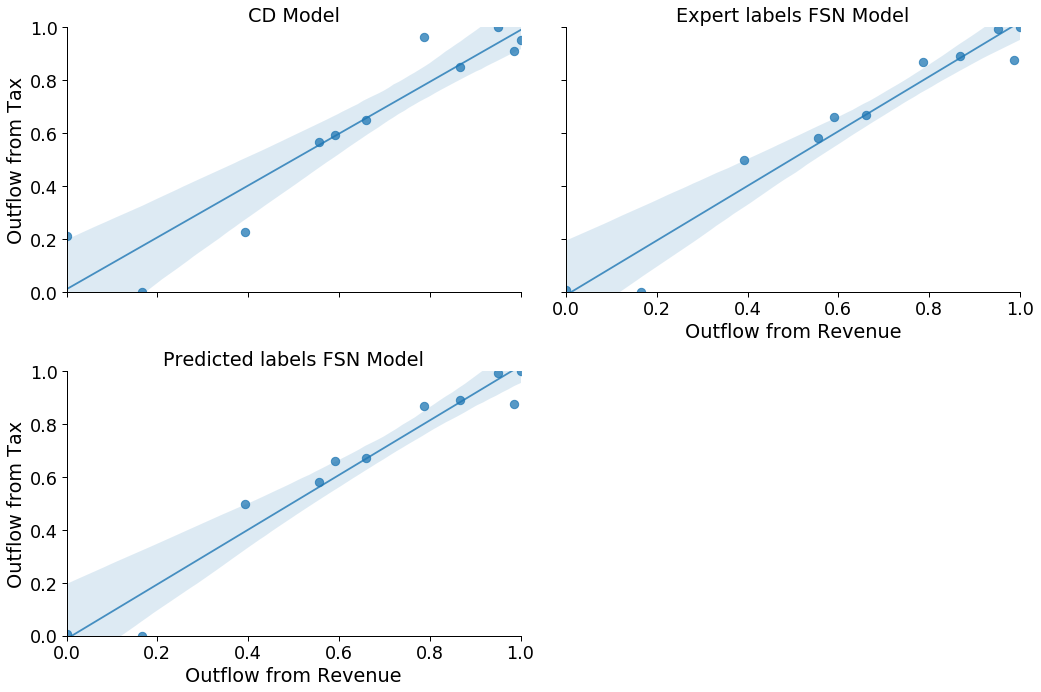

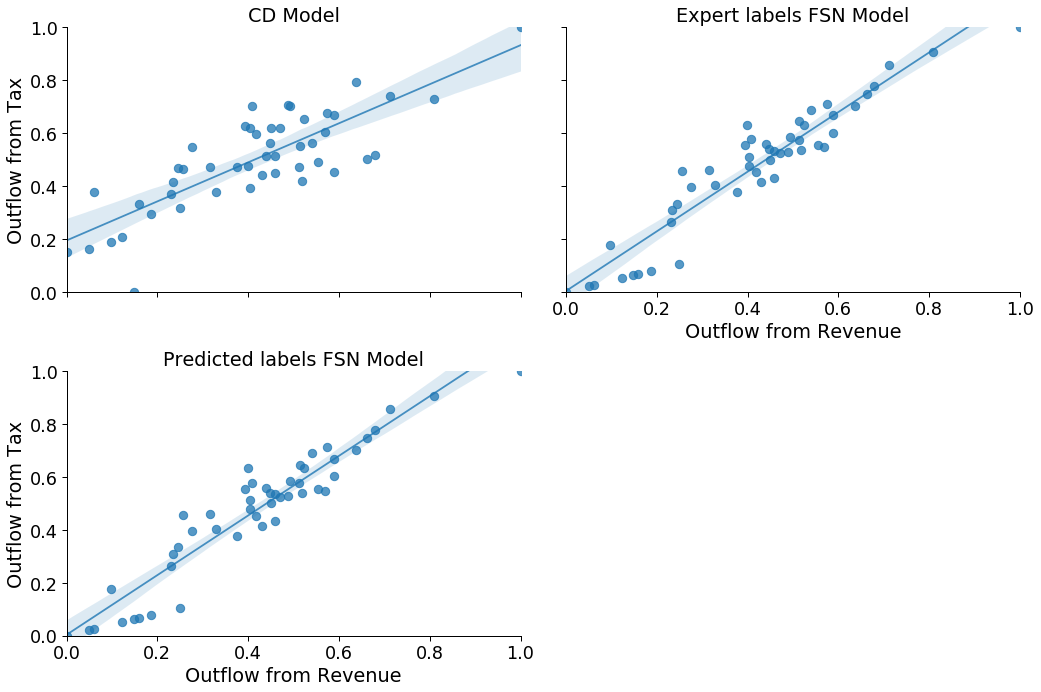

In [131]:
for name, group in TAX_REVENUE_DF.groupby("agg_period"):
    plotRegression(group, title=f"{IMAGE_FOLDER}/TaxRevenue{name}", labels=["Outflow from Revenue", "Outflow from Tax"])

# Repeat the steps above for any other relationship in you data,
## BUT, always update all QUERIES :) 

Alex